In [39]:
import argparse
import sys
from torchvision.datasets import MNIST
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp


In [40]:
cp.random.seed(42)

train_dataset = MNIST(
        root="dataset",
        train=True,
        transform=basic_mnist_augment(train=True),
        download=False
    )
test_dataset = MNIST(
    root="dataset",
    train=False,
    transform=basic_mnist_augment(train=False),
    download=False
)


In [41]:
import numpy as np
train_images, train_labels = preprocess(train_dataset)
test_images,  test_labels  = preprocess(test_dataset)
# 
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_set = (train_images[:50000], train_labels[:50000])

dev_set   = (train_images[50000:], train_labels[50000:])
test_set  = (test_images, test_labels)

In [17]:
# Test 2
layers = [
    Conv(in_channel=1, out_channel=32, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0,2,3), param_shape=(1, 32, 1, 1)),
    ReLU(),
    Pooling(kernel=2),

    Conv(in_channel=32, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1)),
    ReLU(),
    Pooling(kernel=2),

    Flatten(),
    Dropout(rate=0.5),

    Linear(in_channel=64*7*7, out_channel=10, weight_decay=0.001),
]



In [18]:
model     = Model(layers)
optimizer = Adam(model=model, lr=0.001)
loss_fn   = CrossEntropy(model=model)
runner    = RunnerM(model=model, loss=loss_fn, optimizer=optimizer)



Epoch 1/5: 100%|██████████| 782/782 [00:31<00:00, 25.18batch/s, accuracy=1, loss=0.0592]    
train_loss: 0.06846, train_acc: 0.97885
dev_loss  : 0.06757, dev_acc  : 0.98125
### Best model saved to: best_models\2025-05-17_16-51-32\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.98125
Patience Counter Reset to 0

Epoch 2/5: 100%|██████████| 782/782 [00:32<00:00, 23.89batch/s, accuracy=1, loss=0.00624]   
train_loss: 0.04934, train_acc: 0.98501
dev_loss  : 0.05693, dev_acc  : 0.98350
### Best model saved to: best_models\2025-05-17_16-51-32\best_model.pickle
### Best validation accuracy updated: 0.98125 -> 0.98350
Patience Counter Reset to 0

Epoch 3/5: 100%|██████████| 782/782 [00:32<00:00, 23.77batch/s, accuracy=1, loss=0.00255]   
train_loss: 0.03689, train_acc: 0.98888
dev_loss  : 0.04712, dev_acc  : 0.98574
### Best model saved to: best_models\2025-05-17_16-51-32\best_model.pickle
### Best validation accuracy updated: 0.98350 -> 0.98574
Patience Counter Reset to 0

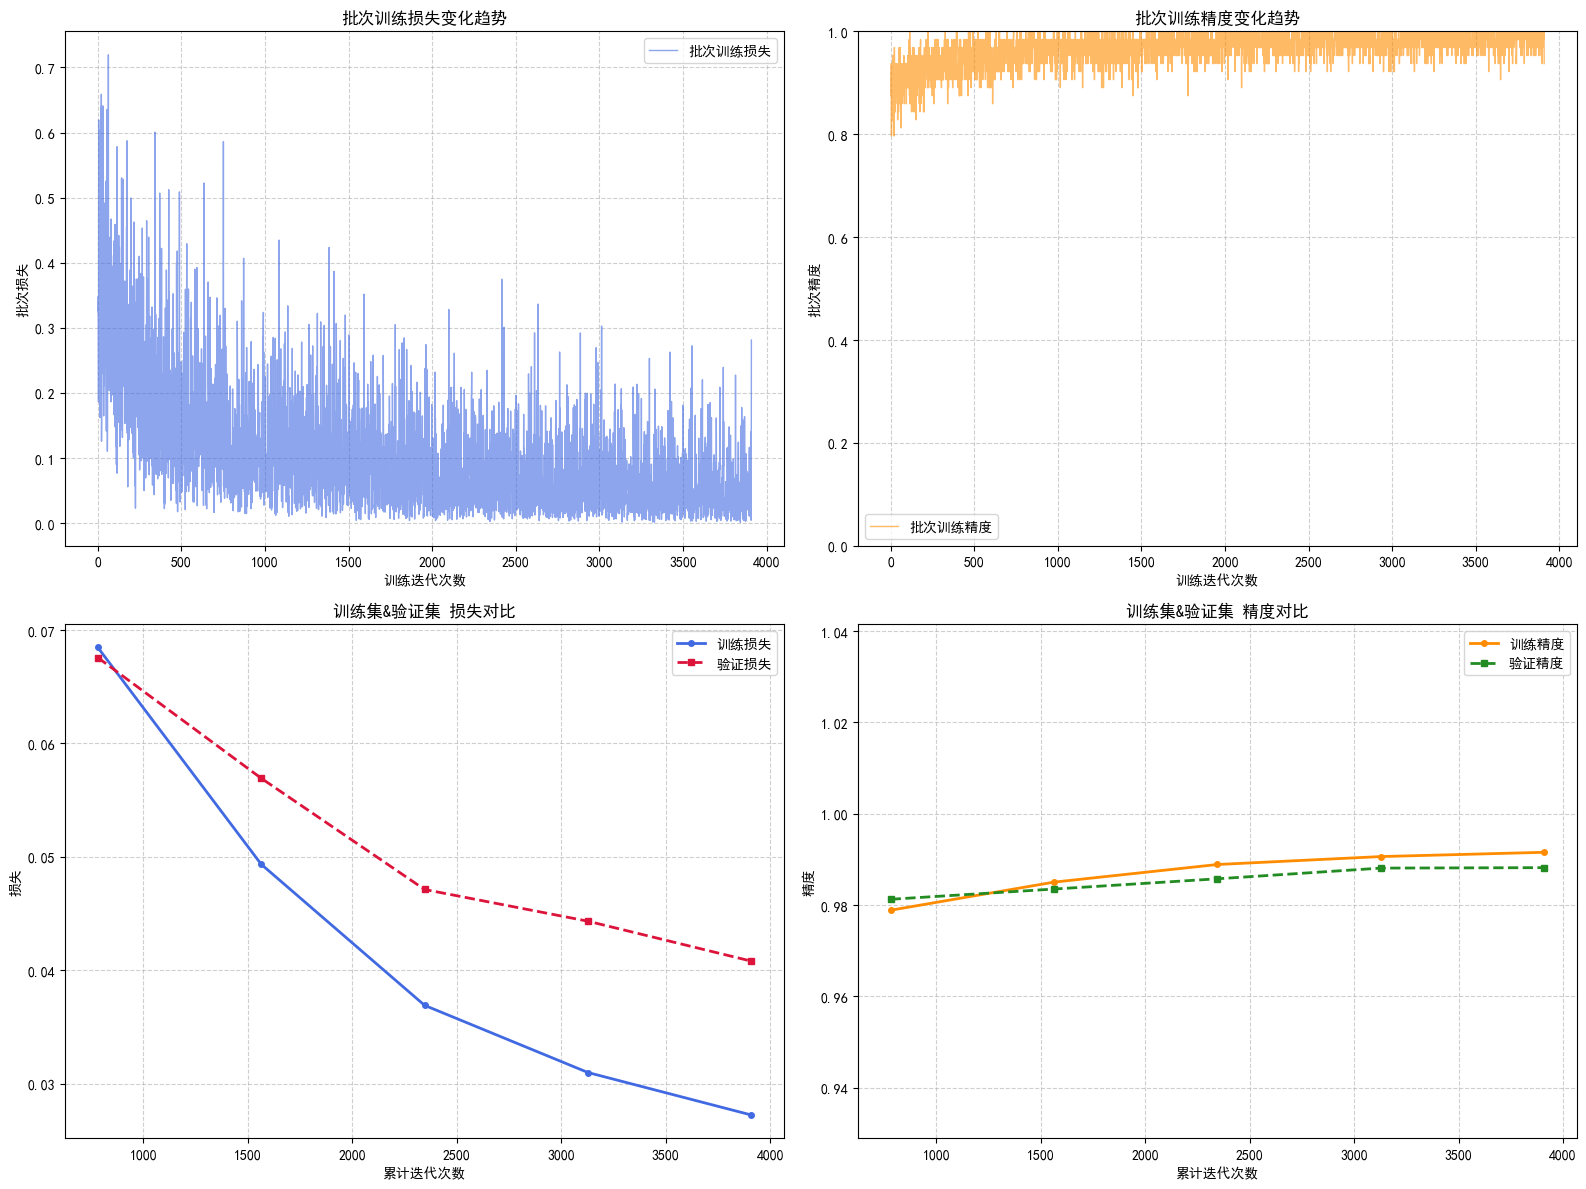

In [20]:
# 3. 训练
runner.train(
    train_set=train_set,
    dev_set=dev_set,
    batch_size=64,
    num_epochs=5,
    scheduler=CosineAnnealingLR(
        optimizer=optimizer,
        T_max=5,
            eta_min=1e-5,
    ),
    strategy=EarlyStopping(
        patience=5,
        delta=0.0,
    ),
    shuffle=True,
    save_dir='best_models'
)



In [21]:
# 4. 测试集评估
test_loss, test_acc = runner.evaluate(test_set, batch_size=64)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.03713, Test accuracy: 0.98796


In [22]:
from mynn.attack import bim_attack
adv_test_images = bim_attack(
    model=model, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=20/255.0  
)

test_set_adv = (adv_test_images, test_labels)

In [24]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.11718, Test accuracy: 0.95979


In [26]:
import matplotlib.pyplot as plt
def plot_images(images, labels, title=""):
    """
    显示前五张图片，自动处理 Cupy/NumPy、范围归一化等
    - images: (N, C, H, W)，可为 Cupy 或 NumPy
    - labels: (N,) 或 (N, C)
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(5):
        ax = axes[i]

        # 取单张图片，并转 (H, W, C)
        img = images[i].transpose(1, 2, 0)

        # 如果是 cupy，则转为 numpy
        if hasattr(img, 'get'):
            img = img.get()

        # 如果像素最大值超过1，说明是 [0, 255]，就归一化
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)  # 保险剪裁，防止 overflow

        ax.imshow(img)
        # 标签显示
        label = labels[i]
        label_text = np.argmax(label) if len(label.shape) > 0 and label.shape[0] > 1 else label
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.show()

Displaying original images...


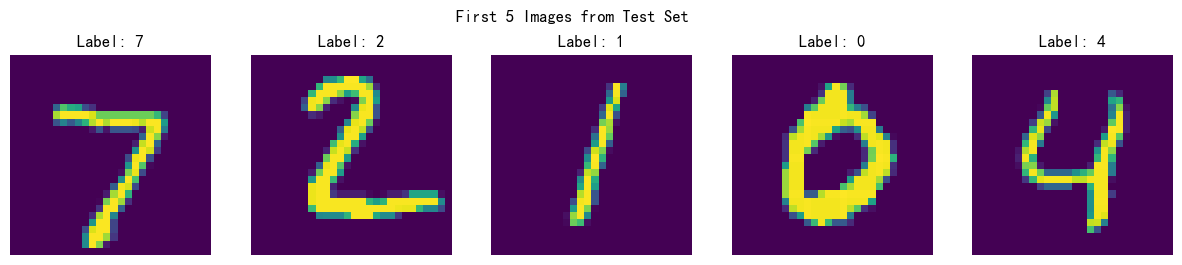

Displaying adversarial images...


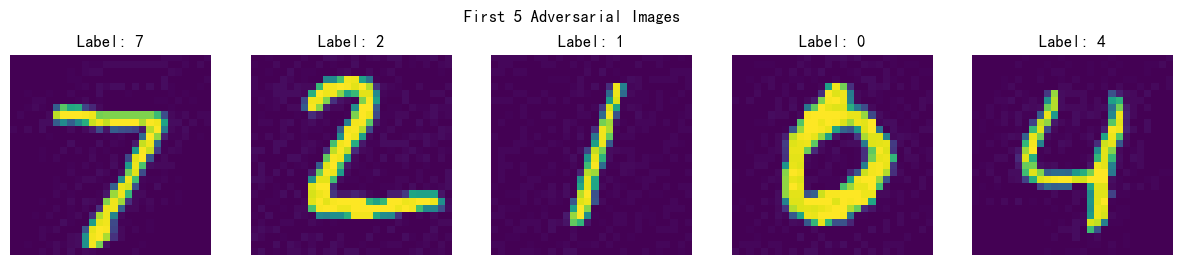

In [27]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")


In [47]:

layers = [
    Conv(in_channel=1, out_channel=32, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0,2,3), param_shape=(1, 32, 1, 1)),
    ReLU(),
    Pooling(kernel=2),

    Conv(in_channel=32, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1)),
    ReLU(),
    Pooling(kernel=2),

    Flatten(),
    Dropout(rate=0.5),

    Linear(in_channel=64*7*7, out_channel=10, weight_decay=0.001),
]

In [48]:
model2     = Model(layers)
optimizer = Adam(model=model2, lr=0.001)
loss_fn   = CrossEntropy(model=model2)
runner2    = RunnerM(model=model2, loss=loss_fn, optimizer=optimizer)

[Adversarial Train] Epoch 1/5: 100%|██████████| 782/782 [00:56<00:00, 13.91batch/s, accuracy=0.625, loss=0.73] 
train_loss: 0.21305, train_acc: 0.93787
dev_loss  : 0.18686, dev_acc  : 0.94668
### Best model saved to: best_models\2025-05-17_17-46-25\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.94668
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/5: 100%|██████████| 782/782 [00:58<00:00, 13.36batch/s, accuracy=0.875, loss=0.272]
train_loss: 0.14934, train_acc: 0.96116
dev_loss  : 0.13479, dev_acc  : 0.96533
### Best model saved to: best_models\2025-05-17_17-46-25\best_model.pickle
### Best validation accuracy updated: 0.94668 -> 0.96533
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/5: 100%|██████████| 782/782 [00:58<00:00, 13.41batch/s, accuracy=1, loss=0.0943]    
train_loss: 0.12425, train_acc: 0.96657
dev_loss  : 0.11404, dev_acc  : 0.96943
### Best model saved to: best_models\2025-05-17_17-46-25\best_model.pickle
### Best validation accura

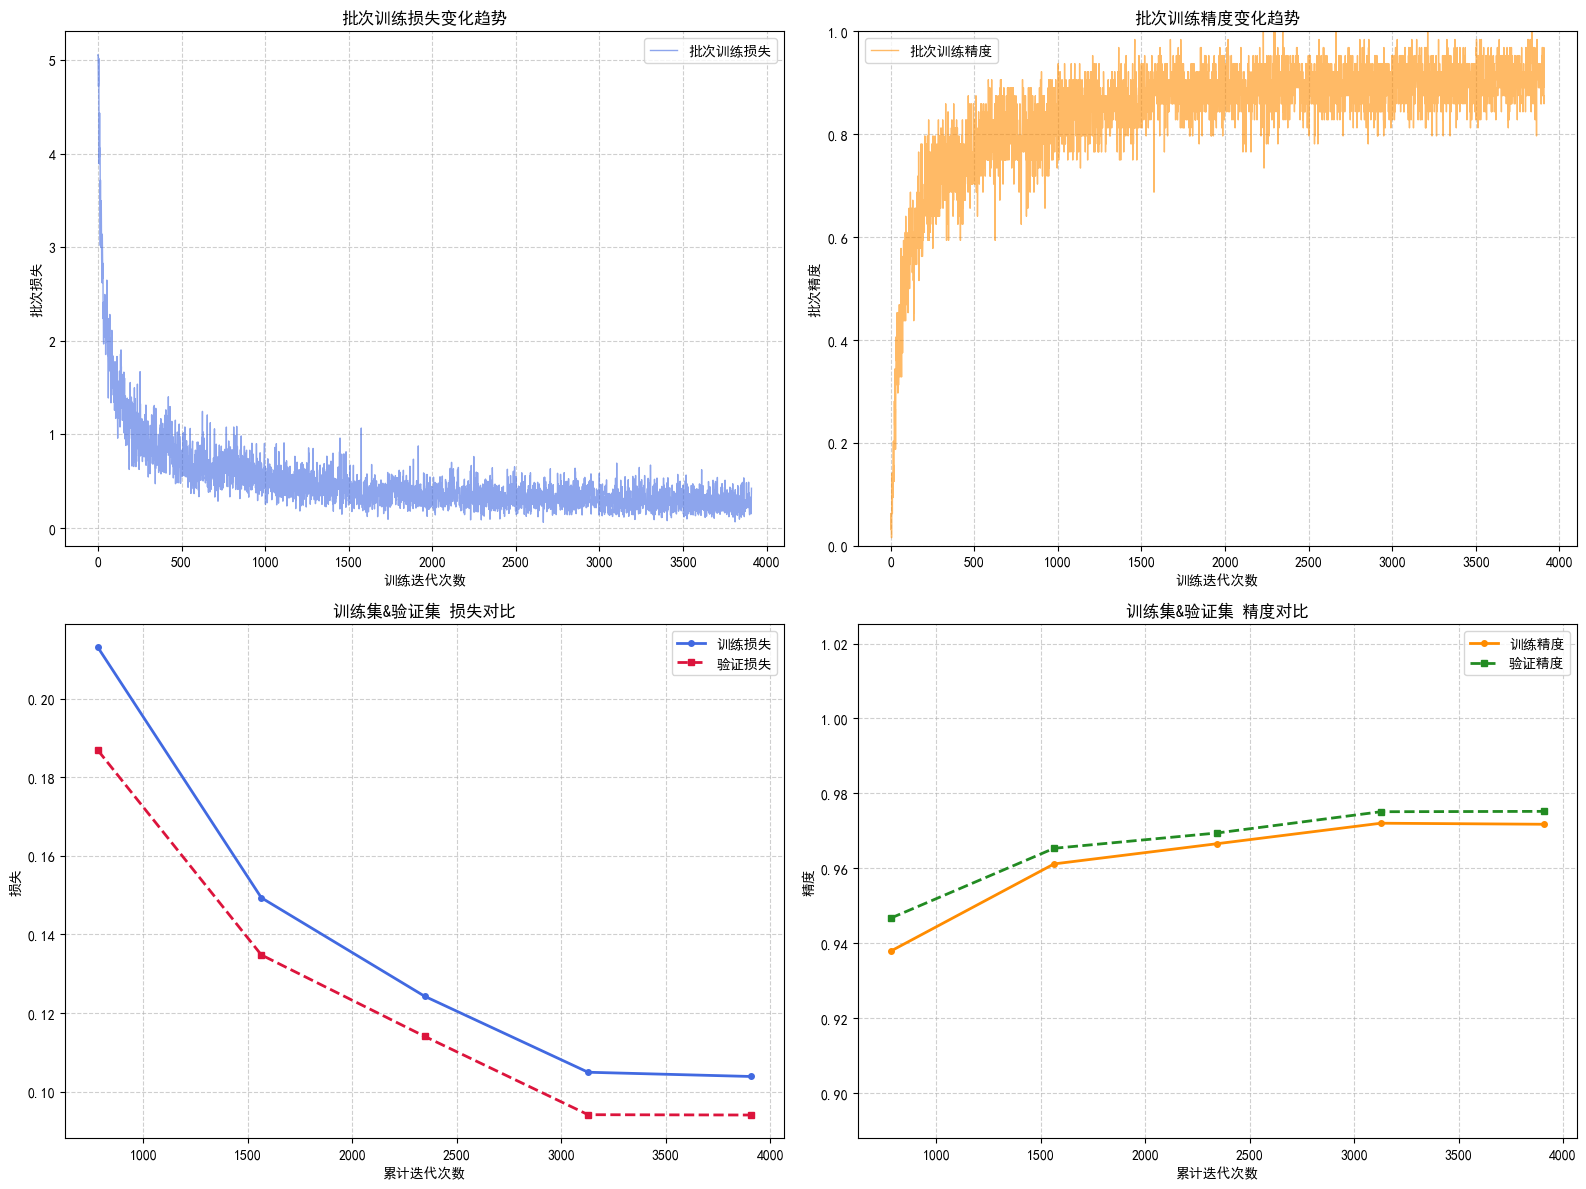

In [49]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=64,
        num_epochs=5,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        shuffle=True,
        save_dir='best_models',
        attack_strategy = 'bim'
    )

In [50]:
test_loss, test_acc = runner2.evaluate(test_set, batch_size=64)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.09696, Test accuracy: 0.97223


In [51]:
adv_test_images = bim_attack(
    model=model2,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=20/255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner2.evaluate(test_set_adv, batch_size=64)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.26496, Test accuracy: 0.91849
